# imports

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

from fastai.vision import *
from fastai.widgets import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# paths

In [0]:
whale_urls = Path('/content/gdrive/My Drive/fastai-v3-nbs/data/whales/urls')
whale_imgs = Path('/content/gdrive/My Drive/fastai-v3-nbs/data/whales/imgs')

whale_urls.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3-nbs/data/whales/urls/killer'),
 PosixPath('/content/gdrive/My Drive/fastai-v3-nbs/data/whales/urls/blue'),
 PosixPath('/content/gdrive/My Drive/fastai-v3-nbs/data/whales/urls/narwhal'),
 PosixPath('/content/gdrive/My Drive/fastai-v3-nbs/data/whales/urls/beluga')]

# download images from urls

In [0]:
for path2urls in whale_urls.ls():
    whale_class = str(path2urls).split('/')[-1]
    dest = whale_imgs/whale_class
    dest.mkdir(exist_ok=True)
    
    download_images(path2urls, dest)
    num_downloaded = len(dest.ls())
    verify_images(dest, delete=True, max_size=500)

    print(f'Done {whale_class}, {num_downloaded} files downloaded, {len(dest.ls())} verfied')

Done beluga, 340 files downloaded, 340 verfied


Done blue, 340 files downloaded, 340 verfied


Done narwhal, 420 files downloaded, 420 verfied


Done killer, 340 files downloaded, 340 verfied


# load data

In [0]:
data = ImageDataBunch.from_folder(
    whale_imgs, 
    valid_pct=.2, 
    train='.', 
    ds_tfms=get_transforms(), 
    size=224, 
    num_workers=4
).normalize(imagenet_stats)

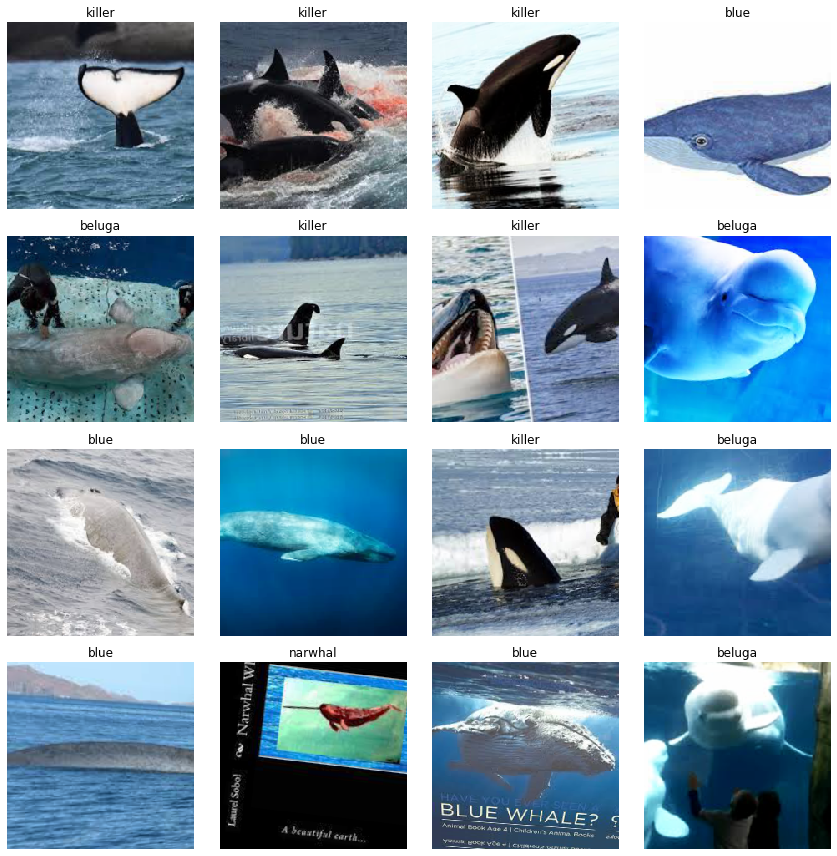

In [0]:
data.show_batch(rows=4, figsize=(12,12))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['beluga', 'blue', 'killer', 'narwhal'], 4, 1152, 288)

# learn

In [0]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.686556,0.690017,0.239583,00:07
1,1.153661,0.542245,0.159722,00:07
2,0.925025,0.542415,0.163194,00:07
3,0.761276,0.556053,0.138889,00:07
4,0.645141,0.489821,0.142361,00:07
5,0.571525,0.490458,0.149306,00:07
6,0.491134,0.480766,0.149306,00:07
7,0.444278,0.480447,0.142361,00:07


In [0]:
learner.save('stage1')

In [0]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


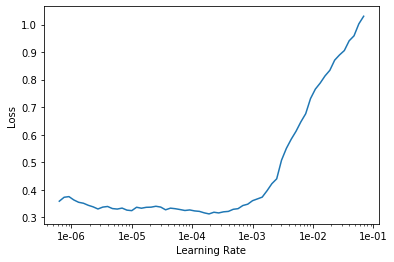

In [0]:
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(4, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.322877,0.454001,0.142361,00:07
1,0.276889,0.448905,0.135417,00:07
2,0.255409,0.440821,0.131944,00:08
3,0.231754,0.436517,0.145833,00:08


In [0]:
learner.save('stage2')

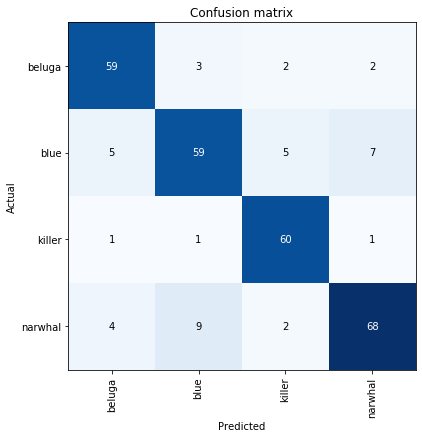

In [0]:
inter = ClassificationInterpretation.from_learner(learner)
inter.plot_confusion_matrix(figsize=(6,6))

# clean data

In [0]:
db = (ImageList.from_folder(whale_imgs)
    .split_none()
    .label_from_folder()
    .transform(get_transforms(), size=224)
    .databunch()
)

In [0]:
learner = cnn_learner(db, models.resnet34, metrics=error_rate)
learner = learner.load('stage2')

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learner)

In [0]:
ImageCleaner(ds, idxs, whale_imgs)

# load clean data


In [0]:
data = data = ImageDataBunch.from_csv(
    whale_imgs, 
    folder=".", 
    valid_pct=0.2, 
    csv_labels='cleaned.csv',
    ds_tfms=get_transforms(), 
    size=224,
    num_workers=4
).normalize(imagenet_stats)

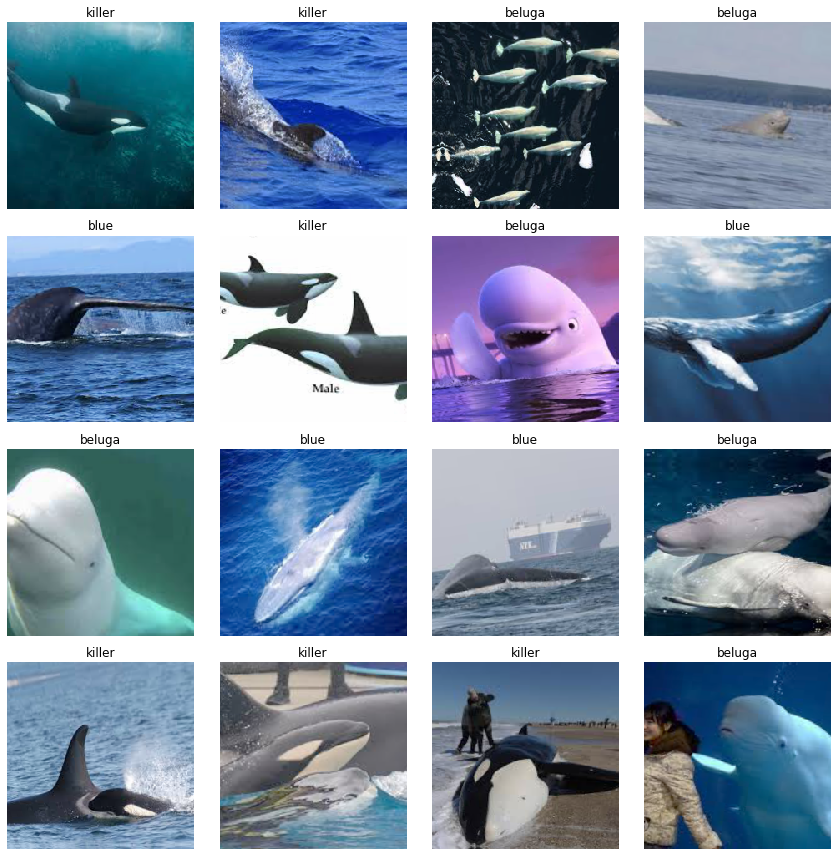

In [0]:
data.show_batch(rows=4, figsize=(12,12))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds) # 4, 1152, 288

(['beluga', 'blue', 'killer', 'narwhal'], 4, 841, 210)

# learn from cleaned data

In [0]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.794145,0.721723,0.219048,00:06
1,1.238229,0.554889,0.128571,00:06
2,0.919038,0.583360,0.128571,00:06
3,0.726142,0.588936,0.123810,00:06
4,0.635790,0.525550,0.119048,00:06
5,0.548794,0.500289,0.114286,00:06
6,0.477497,0.483805,0.109524,00:06
7,0.435868,0.478007,0.119048,00:06


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


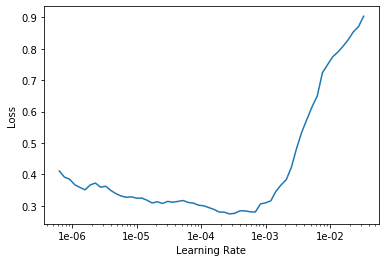

In [0]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(4, max_lr=slice(1e-5, 2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.394868,0.467901,0.114286,00:06
1,0.307197,0.481157,0.104762,00:07
2,0.255610,0.463126,0.100000,00:07
3,0.227112,0.466091,0.090476,00:06


In [0]:
learner.save('stage3')

# augment data with image resize

In [0]:
data = ImageDataBunch.from_csv(
    whale_imgs, 
    folder=".", 
    valid_pct=0.2, 
    csv_labels='cleaned.csv',
    ds_tfms=get_transforms(), 
    size=448, 
    num_workers=4
).normalize(imagenet_stats)

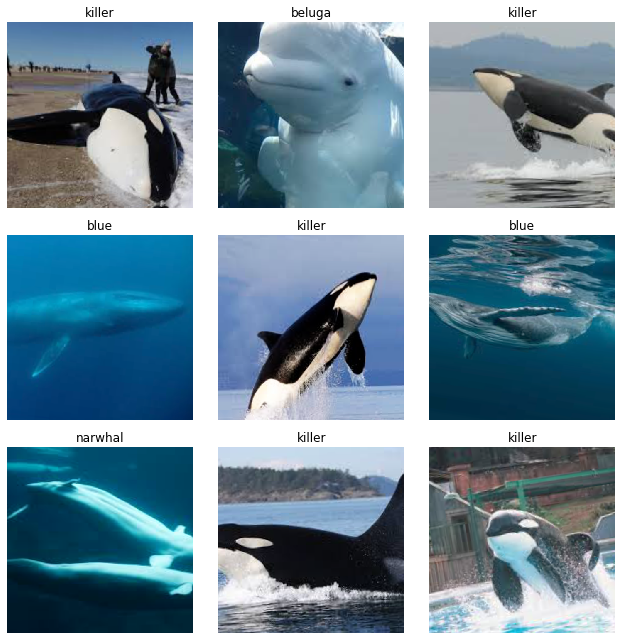

In [0]:
data.show_batch(rows=3, figsize=(9,9))

# learn on aug data

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).load('stage3')

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.712541,0.226481,0.071429,00:20
1,0.620588,0.354333,0.123810,00:19
2,0.560583,0.352349,0.128571,00:19
3,0.502611,0.357350,0.114286,00:19


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


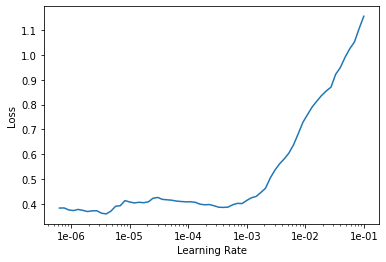

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.492962,1.244976,0.257143,00:20
1,0.633166,1.131740,0.257143,00:20
2,0.657748,1.018251,0.190476,00:20
3,0.568803,0.622642,0.152381,00:20


In [0]:
learn.fit_one_cycle(4, max_lr=5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.288825,0.530779,0.161905,00:20
1,0.320631,0.903446,0.180952,00:20
2,0.333263,0.560554,0.142857,00:20
3,0.282574,0.493081,0.123810,00:20


In [0]:
learn.save('stage4')

In [0]:
data = ImageDataBunch.from_csv(
    whale_imgs, 
    folder=".", 
    valid_pct=0.2, 
    csv_labels='cleaned.csv',
    ds_tfms=get_transforms(), 
    size=112, 
    num_workers=4
).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).load('stage4')

In [0]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.002538,0.539988,0.200000,00:03
1,0.873043,0.468740,0.180952,00:03
2,0.778861,0.436687,0.171429,00:03
3,0.681711,0.500695,0.157143,00:03
4,0.623947,0.436758,0.190476,00:03
5,0.584322,0.476874,0.176190,00:03
6,0.551311,0.447539,0.176190,00:03
7,0.515578,0.446498,0.176190,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


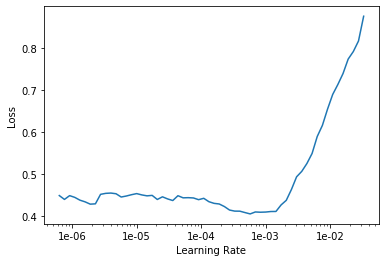

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.480334,0.424930,0.138095,00:03
1,0.404132,0.390473,0.138095,00:03
2,0.356329,0.401832,0.133333,00:03
3,0.309722,0.405162,0.142857,00:03


In [0]:
learn.save('stage5')

In [0]:
learn.fit_one_cycle(8, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.106974,0.395787,0.133333,00:03
1,0.111941,0.411639,0.138095,00:03
2,0.107082,0.377091,0.090476,00:03
3,0.104659,0.451036,0.123810,00:03
4,0.097137,0.434824,0.109524,00:03
5,0.085295,0.394065,0.109524,00:03
6,0.083012,0.398020,0.114286,00:03
7,0.076180,0.400630,0.114286,00:03


In [32]:
cnn_learner(data, models.resnet34, metrics=error_rate).load('stage4').classes

AttributeError: ignored